## Project OpenStreet Map Data Wrangling - Summary

#### Map Area

New York, NY, US

- [https://mapzen.com/data/metro-extracts/metro/new-york_new-york/](https://mapzen.com/data/metro-extracts/metro/new-york_new-york/)

This is the place that I am most familiar in United States, and I do have strong interest to see what the OpenStreet Map Data reveals in this Metro Area.

<img src="img/image.png" alt="Drawing" style="width: 400px;"/>


For OpenStreetMap structure, it represents physical features on the ground (e.g., roads or buildings) using tags attached to its basic data structures (its nodes, ways, and relations). Each tag describes a geographic attribute of the feature being shown by that specific node, way or relation.

- Node: a node is one of the core elements in the OpenStreetMap data model. It consists of a single point in space defined by its latitude, longitude and node id.


- Way: a way is an ordered list of nodes which normally also has at least one tag or is included within a Relation.A way can be open or closed. A closed way is one whose last node on the way is also the first on that way. A closed way may be interpreted either as a closed polyline, or an area, or both.


- Relation: a relation is one of the core data elements that consists of one or more tags and also an ordered list of one or more nodes, ways and/or relations as members which is used to define logical or geographic relationships between other elements. A member of a relation can optionally have a role which describes the part that a particular feature plays within a relation.


#### Summary

Based on the map data, the most important factor is the address, which directly determine the map data quality. In this project, I was desired to check out the data issues especially the relevant location info in the map, and went through the audit, update, transformation, as well as some further analysis in MongoDB after import.

For the address info, based on the my mongodb database, it generally includes
- state
- city
- street
- postcode
- housenumber

And I will organize the data qualities issue associated with the top four factors as the housenumber is hard to tell.

#### Data Quality Issues in My Intrest Region

- State Name: Capitalization and abbreviation are the major issues. Others might be misgrouped like string info or the zipcode info.

- Street Name: The street names are very inconsistent, which include the abbreviation inconsistency, extra ending letters, capitalization, and type error issues.

- City Name: City names do have the same issue as the street name, and capitalization, type error, abbreviation, and extra ending letters are need to be fixed too.

- Postcode: In general the zipcode info is not that bad, only 10 zipcodes include the extension and have more than 5-digit, which is much easier to repair in the Mongo.


#### Data Preprocessing, Auditing, Update

Based on the summarized data quality issues, I planned to audit the city and street name using regular expression, summarized the problem we have and update them to make sure they all consistent. Then we will transform the file to json and import to Mongo for futher analysis and management. For this part the whole process I will put it in another file.
Here is the detailed processing part [Link](http://localhost:8888/notebooks/Desktop/project/Udacity/data_analyst/data_Wrangling/OpenstreetMap/Project%20OpenStreet%20Map%20Data%20Wrangling%20-%20Processing%20Part.ipynb)

### Overview of the Dataset

After importing the map file into MongoDB, I will take advantage of the query in MongoDB to explore our dataset to get more info.

##### Size of the Data

First, after we import the data, I'd like to know the the general info about the New York dataset for open street map.

The original dataset is 2.83G, and the json file it generated is about 4.35GB. For the actual collection we had in the mongodb is 
   > db.map.dataSize()
    
    > 4821778202 

##### Number of distinct users
Here is another way we could check how many distinct users we had
> db.map.distinct("created.user").length

> 5183

##### Number of records

Another way to check the number of nodes and ways. The dataset contains 11578310 nodes and 1816197 ways.

> db.map.distinct("id").length

> db.map.find( { type: "node" } ).length()

> db.map.find( { type: "way" } ).length()


##### Number of chosen type of nodes

###### 1. Top contributing user: Rub21_nycbuildings


    db.map.aggregate([
     {$match:{'created.user':{$exists:1}}},{"$group:{"_id":"$created.user", "count":{'$sum':1}}}, {"$sort": {"count":-1}},{$limit:1}])


###### 2. Which county has more info? 

The top five counties are New York, Nassau, Kings, Bronx, and Queens

    db.map.aggregate([
    {"$group":{"_id":"$gnis:county_name", "count":{'$sum':1}}}, {"$sort": {"count":-1}}
    ])

###### 3. What's the most frequently appeared amenity in the New York Open Street Map?

The top five amenities in the openstreet map are parking, bicycle parking,  place of worship, school and restaurant.

    db.map.aggregate([
    {"$group":{"_id":"$amenity", "count":{'$sum':1}}}, {"$sort":{"count":-1}}])

#### Analysis on the Restaurant with Visualization

Based on the info we had in openstreet map, here I want to dive deep into to look at the restaurant data. Here I simply check which type of cuisine is more popular/ more appeared frequently in our dataset.

    db.map.aggregate([{"$match":{"amenity":'restaurant'}},{"$group":{"_id":"$cuisine", "count":{"$sum":1}}},{"$sort":{"count":-1}},{"$limit":10}])

The list I got are Italian, American, Pizza, Mexican, and Chinese based on their existent frequence in the open street map,which I will show the visualization below.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pymongo import MongoClient

# Connection
client=MongoClient('localhost',27017)

#setup database
mydb=client['udacitymap']

# Query databasename.table_name.
#mydb.map.aggregate({})

Result=mydb.map.aggregate([{"$match":{"amenity":'restaurant'}},{"$group":{"_id":"$cuisine", "count":{"$sum":1}}},{"$sort":{"count":-1}},{"$limit":10}])


/Users/apple/anaconda/envs/py2Udacity/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
RESULT=[]
for i in Result:
    RESULT.append({"Type of Cuisine":i["_id"],"Popularity":i['count']})

In [3]:
df=pd.DataFrame(RESULT)
#df

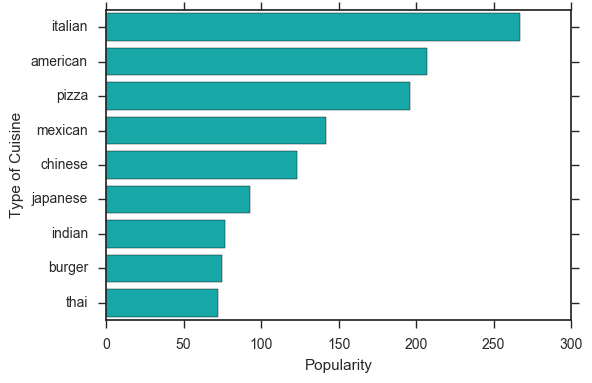

In [4]:
# dataset loading - for the data frame, it works for the seaborn//
# for other read in, it might need to yse sns.load_dataset()

#dataset=sns.load_dataset(df)

sns.set(style='ticks')
g=sns.barplot(x="Popularity",y="Type of Cuisine",data=df,color='c')

plt.show()

##### Suggestion

As what we could see above, in the existent restaurants on openstreet map, there are still a lot type of cuisine info that were missing. If we could use either yelp or google API, it will help us to bring more useful info. 

This issue also exist in other amenities and might be worse, like parkings. If we could bring more info like the capacity, operation hours either from the drivers like taxi or uber drivers, or corporated with some companies like car rent or uber to share the mapping info and let them to collect those info.

Another issue about the data quality itself as the whole process suffered, if we could set up certain standards to check out the uploading info when the users collected and input, it would be much better for the map data quality. 


#### Review

The whole process especially from the transformation to the mongoDB, I went through the whole process on how the data is explored, preprocessed,and organized into the database.

The messy data require too much efforts to organize and reorganize. In the open street map dataset, there are too many inconsistency, and what I checked is the address part that might be more important in the street map. Those inconsistency might bring less info that rooted in the dataset, and it takes time to find those inconsistency and reconcile them.

> For the benifits of this improvement,

- It will be helpful to make the data more prepared and well cleaned to be used in different analysis, especially the analysis based on geoinfo.


- Allowing continuous updating and quality control in the MongoDB.

> Anticipated Problems:

- Processing speed: the file I choosed is 2.83 G in total, and I choose to only update city and street names, but it still takes too much time when loop all the records in the dataset. If we decide to apply the improvement to the whole open street map, we might need to think about the optimized algorithm or adopted Map reduce to level up the processing speed, which would be helpful to the implementation.


- There are some location data not starting with addr but gnis, which are not put in the address part in Mongo. It might make the dataset a little bit unorganized. But if we decide to put them in, if they are related to the same category like city name, but their value is different, how do we adjust it. The way I had right now is to put them also in the address part with gnis in their keys.
